# Toronto Dwellings Analysis Dashboard

In this notebook, you will compile the visualizations from the previous analysis into functions to create a Panel dashboard.

In [1]:
# import
from pathlib import Path
import os
from dotenv import load_dotenv
import pandas as pd
import panel as pn

import plotly.express as px
pn.extension('plotly')

import hvplot.pandas
import matplotlib.pyplot as plt

from panel.interact import interact
from panel import widgets

In [2]:
# Read the Mapbox API key
load_dotenv(dotenv_path = Path("C:/Users/Leon/API_keys/.env"))
map_box_api = os.getenv("MAPBOX")
px.set_mapbox_access_token(map_box_api)
print(type(map_box_api))

<class 'str'>


# Import Data

In [3]:
# Import the CSVs to Pandas DataFrames
file_path = Path("Data/toronto_neighbourhoods_census_data.csv")
to_data = pd.read_csv(file_path, index_col="year")

file_path = Path("Data/toronto_neighbourhoods_coordinates.csv")
df_neighbourhood_locations = pd.read_csv(file_path)

- - -

## Panel Visualizations

In this section, you will copy the code for each plot type from your analysis notebook and place it into separate functions that Panel can use to create panes for the dashboard. 

These functions will convert the plot object to a Panel pane.

Be sure to include any DataFrame transformation/manipulation code required along with the plotting code.

Return a Panel pane object from each function that can be used to build the dashboard.

Note: Remove any `.show()` lines from the code. We want to return the plots instead of showing them. The Panel dashboard will then display the plots.

### Global available data

In [4]:
# Calculate the sum number of dwelling types units per year (hint: use groupby)
num_dewlling_yr = to_data.groupby(to_data.index).sum().drop(
    columns=["average_house_value","shelter_costs_owned","shelter_costs_rented"],
)

num_dewlling_yr.sort_index(inplace=True)

# Calculate the average monthly shelter costs for owned and rented dwellings
ave_monthly_costs = to_data[["shelter_costs_owned","shelter_costs_rented"]].groupby(to_data.index).mean()

# Calculate the average house value per year
average_house_value = to_data["average_house_value"].groupby(to_data.index).mean()

# Create a new DataFrame with the mean house values by neighbourhood per year
mean_neighbourbood = to_data[["neighbourhood", "average_house_value"]].groupby(
    ["year", "neighbourhood"]).mean().reset_index()

# Fetch the data of all dwelling types per year
num_dewelling_types = to_data.drop(columns=["average_house_value","shelter_costs_owned","shelter_costs_rented"])

# Getting the data from the top 10 expensive neighbourhoods
expensive_neighbourhoods_test = to_data.groupby("neighbourhood").mean().sort_values(
    "average_house_value", ascending=False).reset_index()

expensive_neighbourhoods = expensive_neighbourhoods_test[[
    "neighbourhood", 
    "average_house_value"
    ]].set_index("neighbourhood").nlargest(10, "average_house_value")

# Calculate the mean values for each neighborhood
expensive_neighbourhoods_test2 = to_data.groupby("neighbourhood").mean().reset_index()

# Join the average values with the neighbourhood locations
joined_df = pd.concat([df_neighbourhood_locations, expensive_neighbourhoods_test2.drop(columns="neighbourhood")], 
    axis = "columns", join="inner")

# Creating a filter_list to select Top 10 most expensive neighbourhoods
filter_list = list(expensive_neighbourhoods.reset_index()["neighbourhood"])

# Fetch the data from all expensive neighbourhoods per year.
expensive_neighbourhoods_yr = to_data.loc[to_data["neighbourhood"].isin(filter_list)].reset_index()

### Panel Visualization Functions

In [5]:
# Define Panel visualization functions
def neighbourhood_map():
    """Neighbourhood Map"""
    map_neighbourhood= px.scatter_mapbox(
    joined_df,
    title="Average House Values in Toronto",
    lat="lat",
    lon="lon",
    hover_name="neighbourhood",
    hover_data=joined_df.iloc[:, 3:],
    color="average_house_value",
    size="average_house_value",
    size_max = 14,
    color_continuous_scale=px.colors.cyclical.IceFire,
    zoom=9,
    height=700,
    width=900,
    )
    
    return map_neighbourhood

def create_bar_chart(data, title, xlabel, ylabel, color):
    
    bar_chart = data.hvplot.bar(
    title=title,
    xlabel=xlabel,
    ylabel=ylabel,
    color=color,
    rot=90,
    height=500,
    width=500,
    ).opts(yformatter="%0.0f")
    
    return bar_chart

def create_line_chart(data, title, xlabel, ylabel, color):
    """
    Create a line chart based in the data argument.
    """
    
    line_chart=data.hvplot.line(
    title=title,
    xlabel=xlabel,
    ylabel=ylabel,
    color=color,
    height=500,
    width=500,
    ).opts(yformatter="%0.0f")
    
    return line_chart

"attention!"
def average_house_values():
    """Average house values per year."""
    
    line_chart_average_house_value=average_house_value.hvplot.line(
    title="Average House Value in Toronto",
    xlabel="Year",
    ylabel="Avg. House Value",
    height=500,
    width=500,
    ).opts(yformatter="%0.0f",axiswise=True)
    
    return line_chart_average_house_value

"attention!"
def average_value_by_neighbourhood():
    """Average house values by neighbourhood."""
    
    hvplot_avg_neighbourbood=mean_neighbourbood.set_index("year").hvplot.line(
    groupby="neighbourhood",
    xlabel="Year",
    ylabel="Avg. House Value",
    height=300,
    ).opts(yformatter="%.0f",axiswise=True)
    
    return hvplot_avg_neighbourbood

def number_dwelling_types():
    """Number of dwelling types per year"""
    
    hvplot_num_dewelling_types = num_dewelling_types.hvplot.bar(
    groupby="neighbourhood",
    rot=90,
    xlabel="Year",
    ylabel="Dewelling Type Units",
    height=500,
    widget_location="right"
    )
    
    return hvplot_num_dewelling_types

def average_house_value_snapshot():
    """Average house value for all Toronto's neighbourhoods per year."""

    facet_fig=px.bar(
    mean_neighbourbood, 
    title="Average House Values in Toronto per Neighbourhood",
    x="neighbourhood", 
    y="average_house_value", 
    facet_row="year",
    color="average_house_value",
    labels={"average_house_value":"Avg. House Value",
                "neighbourhood": ""},
    height=1000,
    )
    
    return facet_fig

"attention!"
def top_most_expensive_neighbourhoods():
    """Top 10 most expensive neighbourhoods."""
    
    hvplot_expensive_neighbourhoods = expensive_neighbourhoods.hvplot.bar(
    yformatter="%.0f",
    title="Top 10 Expensive Neighbourhoods in Toronto",
    rot=90,
    xlabel="Neighbourhood",
    ylabel="Avg. House Value",
    height=500,
    widget_location="right",
    )
    
    return hvplot_expensive_neighbourhoods

def sunburts_cost_analysis():
    """Sunburst chart to conduct a costs analysis of most expensive neighbourhoods in Toronto per year."""
    
    sunburst_fig=px.sunburst(
    expensive_neighbourhoods_yr,
    path=["year", 'neighbourhood'],
    values="average_house_value",
    height=500,
    width=900,
    color="shelter_costs_owned",
    color_continuous_scale="Blues",
    title="Costs Analysis of Most Expensive Neighbourhoods in Toronto per Year",
    hover_data=expensive_neighbourhoods_yr.loc[:,["shelter_costs_owned","shelter_costs_rented"]],
    )
    
    return sunburst_fig

## Panel Dashboard

In this section, you will combine all of the plots into a single dashboard view using Panel. Be creative with your dashboard design!

In [6]:
# Create a Title for the Dashboard
title = "# Real Estate Analysis of Toronto from 2001 to 2016"


# Define a welcome text
welcome = pn.Column(
    "This dashboard presents a visual analysis of historical values, dwelling types per neighbourhood and dwelling costs in Toronto, Ontario according tp census data from 2001 to 2016.", 
    "You can navigate through the tabs above to explore more details about the evolution of the real estate market on the 6 across these years.",
    neighbourhood_map()
)


# Create a tab layout for the dashboard
yearly_market_analysis = pn.Column(
    pn.Row(
    create_bar_chart(num_dewlling_yr.loc[2001], "Dewelling Types in Toronto in 2001", "2001",  "Dewelling Type Units", "red"),
    create_bar_chart(num_dewlling_yr.loc[2006], "Dewelling Types in Toronto in 2001", "2006",  "Dewelling Type Units", "blue")
    ),                        
    pn.Row(
    create_bar_chart(num_dewlling_yr.loc[2011], "Dewelling Types in Toronto in 2001", "2011",  "Dewelling Type Units", "orange"),
    create_bar_chart(num_dewlling_yr.loc[2016], "Dewelling Types in Toronto in 2001", "2016",  "Dewelling Type Units", "fuchsia")
    )
)


shelter_costs_house_value = pn.Column(
    create_line_chart(
        ave_monthly_costs["shelter_costs_owned"],
        "Average Monthly Shelter Cost for Owned Dwellings in Toronto",
        "Year",
        "Avg Monthly Shelter Costs",
        "blue",
    ),
    create_line_chart(
        ave_monthly_costs["shelter_costs_rented"],
        "Average Monthly Shelter Cost for Rented Dwellings in Toronto",
        "Year",
        "Avg Monthly Shelter Costs",
        "orange",
    ),
    average_house_values()
)


neighbourhood_analysis = pn.Row(
    pn.Column(
        average_value_by_neighbourhood(),
        number_dwelling_types()
    ),
    average_house_value_snapshot()
)


top_expensive_neighbourhoods = pn.Row(
    top_most_expensive_neighbourhoods(),
    sunburts_cost_analysis()
)


# Create the main dashboard
dashboard = pn.Column(
    title,
    pn.Tabs(
        ("welcome", welcome),
        ("Yearly Market Analysis", yearly_market_analysis),
        ("Shelter Costs Vs. House Value", shelter_costs_house_value),
        ("Neighbourhood Analysis", neighbourhood_analysis),
        ("Top Expensive Neighbourhoods", top_expensive_neighbourhoods)
    )
)


## Serve the Panel Dashboard

In [7]:
dashboard.servable()

Column
    [0] Markdown(str)
    [1] Tabs
        [0] Column
            [0] Markdown(str)
            [1] Markdown(str)
            [2] Plotly(Figure)
        [1] Column
            [0] Row
                [0] HoloViews(Bars)
                [1] HoloViews(Bars)
            [1] Row
                [0] HoloViews(Bars)
                [1] HoloViews(Bars)
        [2] Column
            [0] HoloViews(Curve)
            [1] HoloViews(Curve)
            [2] HoloViews(Curve)
        [3] Row
            [0] Column
                [0] Row
                    [0] HoloViews(DynamicMap)
                    [1] Column
                        [0] WidgetBox
                            [0] Select(margin=(20, 20, 20, 20), name='neighbourhood', options=['Agincourt North', ...], value='Agincourt North', width=250)
                        [1] VSpacer()
                [1] Row
                    [0] HoloViews(DynamicMap, widget_location='right')
                    [1] Column
                        [0] VSpacer()
                        [1] WidgetBox
                            [0] Select(margin=(20, 20, 20, 20), name='neighbourhood', options=['Agincourt North', ...], value='Agincourt North', width=250)
                        [2] VSpacer()
            [1] Plotly(Figure)
        [4] Row
            [0] HoloViews(Bars, widget_location='right')
            [1] Plotly(Figure)

In [8]:
dashboard.show()

Launching server at http://localhost:49198


# Debugging

Note: Some of the Plotly express plots may not render in the notebook through the panel functions.

However, you can test each plot by uncommenting the following code

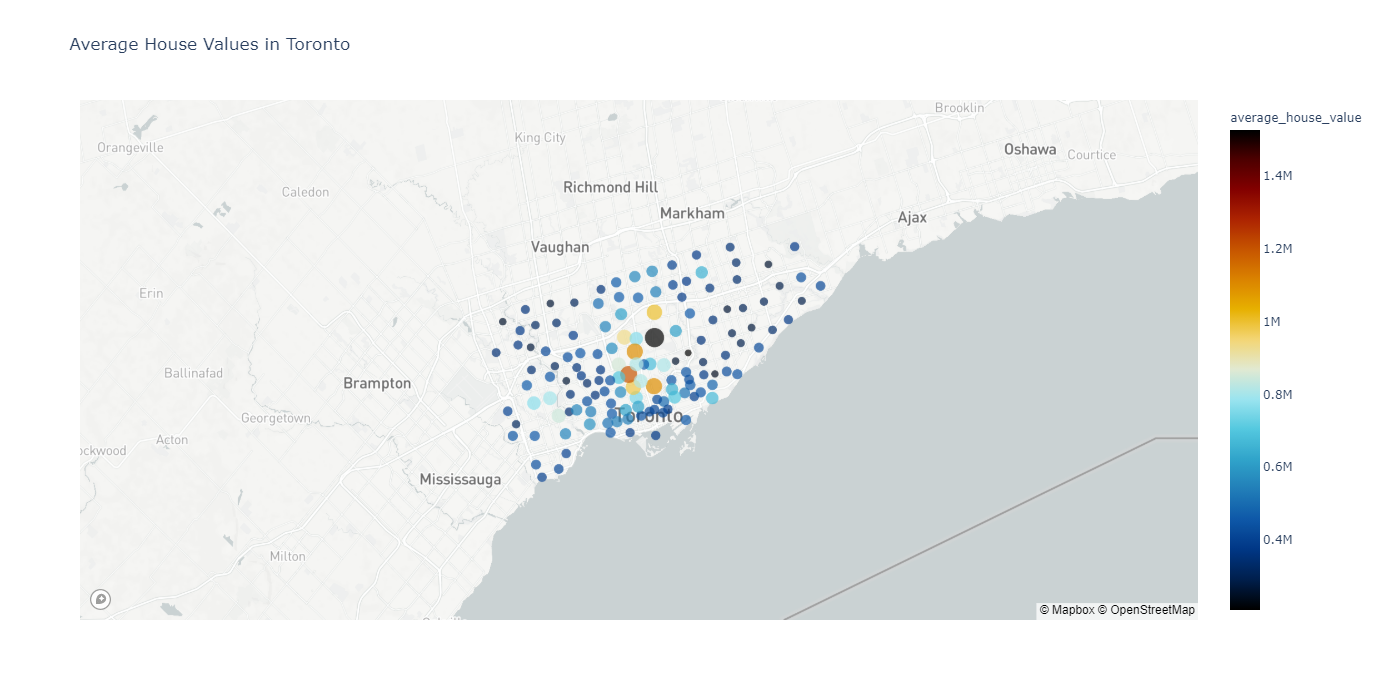

In [9]:
neighbourhood_map().show()

In [10]:
# create_bar_chart(data, title, xlabel, ylabel, color)
# # Bar chart for 2001
create_bar_chart(num_dewlling_yr.loc[2001], "Dwelling Types in Toronto in 2001", "2001", "Dwelling Type Units", "red")

# # Bar chart for 2006
create_bar_chart(num_dewlling_yr.loc[2006], "Dwelling Types in Toronto in 2006", "2006", "Dwelling Type Units", "blue")

# # Bar chart for 2011
create_bar_chart(num_dewlling_yr.loc[2011], "Dwelling Types in Toronto in 2011", "2011", "Dwelling Type Units", "orange")

# # Bar chart for 2016
create_bar_chart(num_dewlling_yr.loc[2016], "Dwelling Types in Toronto in 2016", "2016", "Dwelling Type Units", "magenta")

:Bars   [index]   (2016)

In [11]:
# create_line_chart(data, title, xlabel, ylabel, color)
# # Line chart for owned dwellings
create_line_chart(ave_monthly_costs["shelter_costs_owned"], "Average Monthly Shelter Cost for Owned Dwellings in Toronto", "Year", "Avg Monthly Shelter Costs", "blue")

# # Line chart for rented dwellings
create_line_chart(ave_monthly_costs["shelter_costs_rented"], "Average Monthly Shelter Cost for Rented Dwellings in Toronto", "Year", "Avg Monthly Shelter Costs", "orange")

:Curve   [year]   (shelter_costs_rented)

In [12]:
average_house_values()

:Curve   [year]   (average_house_value)

In [13]:
average_value_by_neighbourhood()

:DynamicMap   [neighbourhood]
   :Curve   [year]   (average_house_value)

In [14]:
number_dwelling_types()

Row
    [0] HoloViews(DynamicMap, widget_location='right')
    [1] Column
        [0] VSpacer()
        [1] WidgetBox
            [0] Select(margin=(20, 20, 20, 20), name='neighbourhood', options=['Agincourt North', ...], value='Agincourt North', width=250)
        [2] VSpacer()

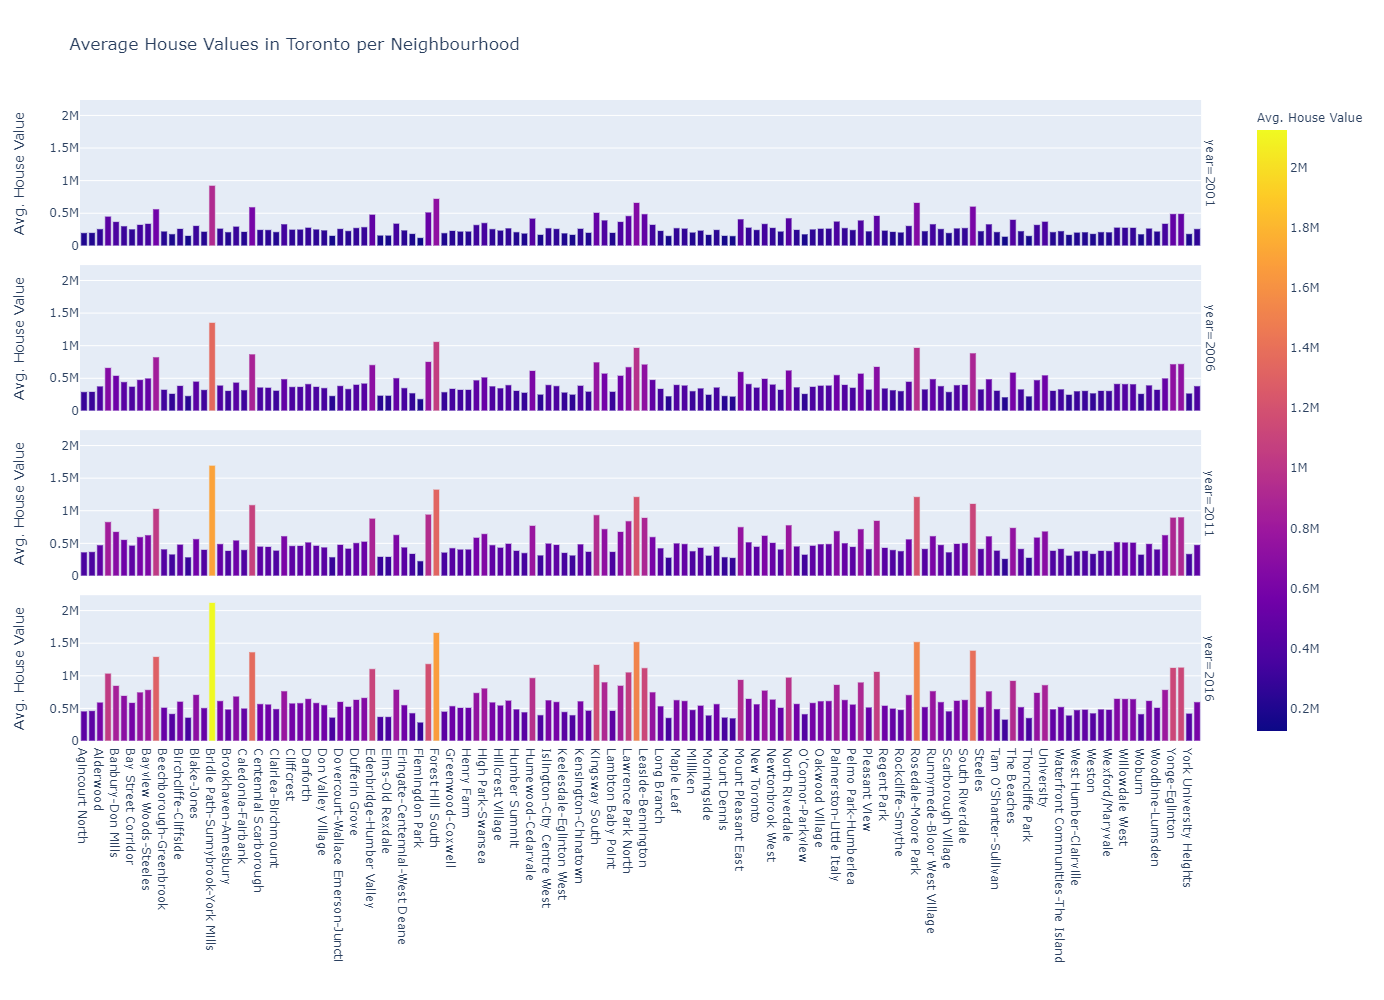

In [15]:
average_house_value_snapshot()

In [16]:
top_most_expensive_neighbourhoods()

HoloViews(Bars, widget_location='right')

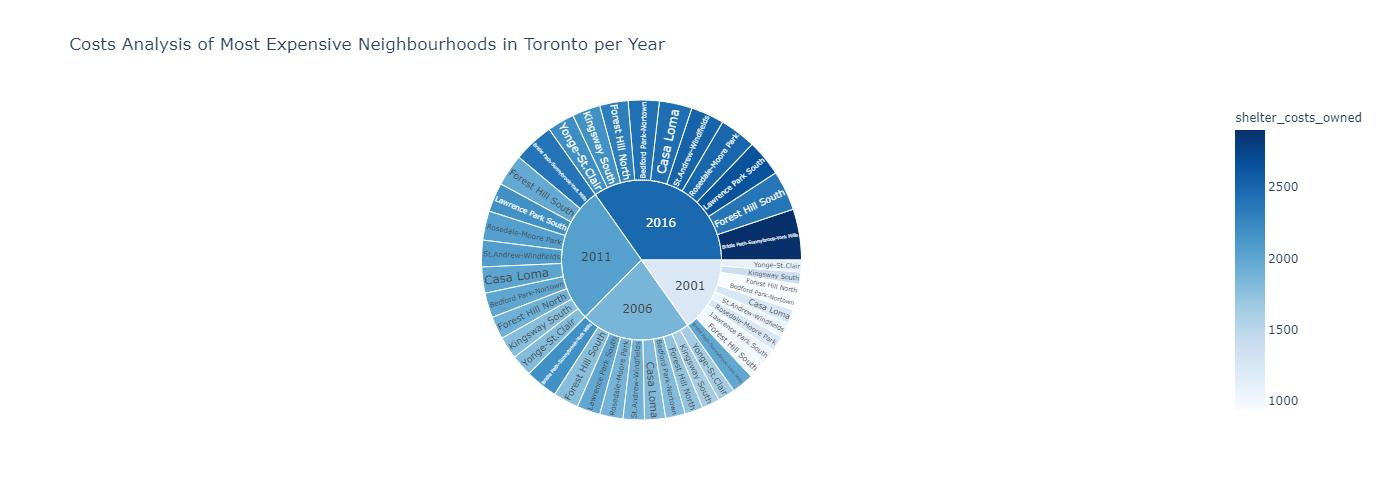

In [17]:
sunburts_cost_analysis()